# Compartmental Models

[1-2 sentences introducing compartmental models. What are they for?]

## SIR Model

The SIR model can be described by the following ODEs:
- $\frac{dS}{dt} = -\frac{\beta I S}{N}$
- $\frac{dI}{dt} = \frac{\beta I S}{N} - \gamma I$
- $\frac{dR}{dt} = \gamma I$

The variables:
- $S$ represents the number of susceptible individuals
- $I$ represents the number of infected individuals
- $R$ represents the number of recovered individuals
- $N$ is the total population size

The parameters:
- $\beta$ represents the transmission rate
- $\gamma$ represents the recovery rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# SIR computational model
def sir_model(
    y,      # a tuple with (S, I, R)
    t, 
    transmission_rate, # beta
    recovery_rate,     # gamma
):
    S, I, R = y
    N = S + I + R
    dSdt = -transmission_rate * S * I / N
    dIdt = transmission_rate * S * I / N - recovery_rate * I
    dRdt = recovery_rate * I
    return dSdt, dIdt, dRdt
    

In [3]:
# initial comditions

## Total population
N = 1000
I0 = 1
R0 = 0
S0 = N - I0 - R0
y0 = S0, I0, R0  # put the population in a tuple
transmission_rate = 0.4  # transmission rate
recovery_rate = 0.1  # recovery rate

# time points (in days)
t = np.linspace(0, 365, 365)

# simulate with odeint
soln = odeint(sir_model, y0, t, args=(transmission_rate, recovery_rate))
S, I, R = soln.T

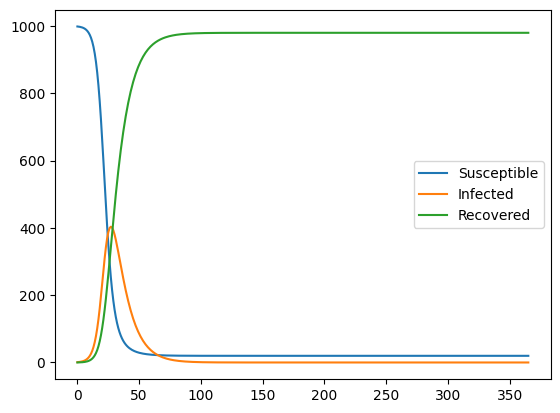

In [4]:
# plotting
plt.figure()
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.legend()
# TODO -- add title xlabel, ylabel

## Extending the SIR model to include Spatial Dynamics
[2 sentences explaining what this is for]

### Spatial Models
we divide the population into regions (or compartments). Each compartment has its own S, I, R populations, and the disease can spread within and between these compartments. This allows us to model spread over time and over space

## generic SIR model for any number of regions

In [30]:
def generic_spatial_sir(
    y,                 # all populations, including S, I, R for each location
    t, 
    infection_rate,    # float, single value for infection
    recovery_rate,     # float, single value for recovery
    migration_matrix,  # represents movement between regions (len(N)xlen(N) matrix)
):
    N = []
    for i in range(0, len(y), 3):
        sum_of_3 = sum(y[i:i+3])
        N.append(sum_of_3)
        
    num_regions = len(N)
    derivatives = np.zeros(num_regions * 3)  # initialize all derivatives

    for loc in range(num_regions):
        S, I, R = y[loc*3:(loc+1)*3]  # extract S, I, R for this location

        # Calculate net movement for susceptible and infected individuals
        net_S_movement = sum(
            migration_matrix[j][loc] * y[j*3] - migration_matrix[loc][j] * S for j in range(num_regions))
        net_I_movement = sum(
            migration_matrix[j][loc] * y[j*3+1] - migration_matrix[loc][j] * I for j in range(num_regions))
        net_R_movement = sum(
            migration_matrix[j][loc] * y[j*3+2] - migration_matrix[loc][j] * R for j in range(num_regions))

        # SIR model equations with mobility
        dSdt = -infection_rate * S * I / N[loc] + net_S_movement
        dIdt = infection_rate * S * I / N[loc] - recovery_rate * I + net_I_movement
        dRdt = recovery_rate * I + net_R_movement
        
        # Update derivatives
        derivatives[loc*3:(loc+1)*3] = [dSdt, dIdt, dRdt]

    return derivatives


In [40]:
# run simulation for 3 regions
infection_rate = 0.2
recovery_rate = 0.03
migration_matrix = [[0,    0.1,  0.2], 
                    [0.1,  0,    0.1], 
                    [0.05, 0.05, 0]
                   ]  # len(N) X len(N) matrix with migration rates

# initial populations [S1, I1, R1, S2, I2, R2, S3, I3, R3]
initial_populations = [999, 1, 0, 2000, 0, 0, 500, 0, 0]

time_vec = np.linspace(0, 150, 1000)

soln = odeint(
    generic_spatial_sir, 
    initial_populations, 
    time_vec, 
    args=(infection_rate, 
          recovery_rate, 
          migration_matrix)
).T

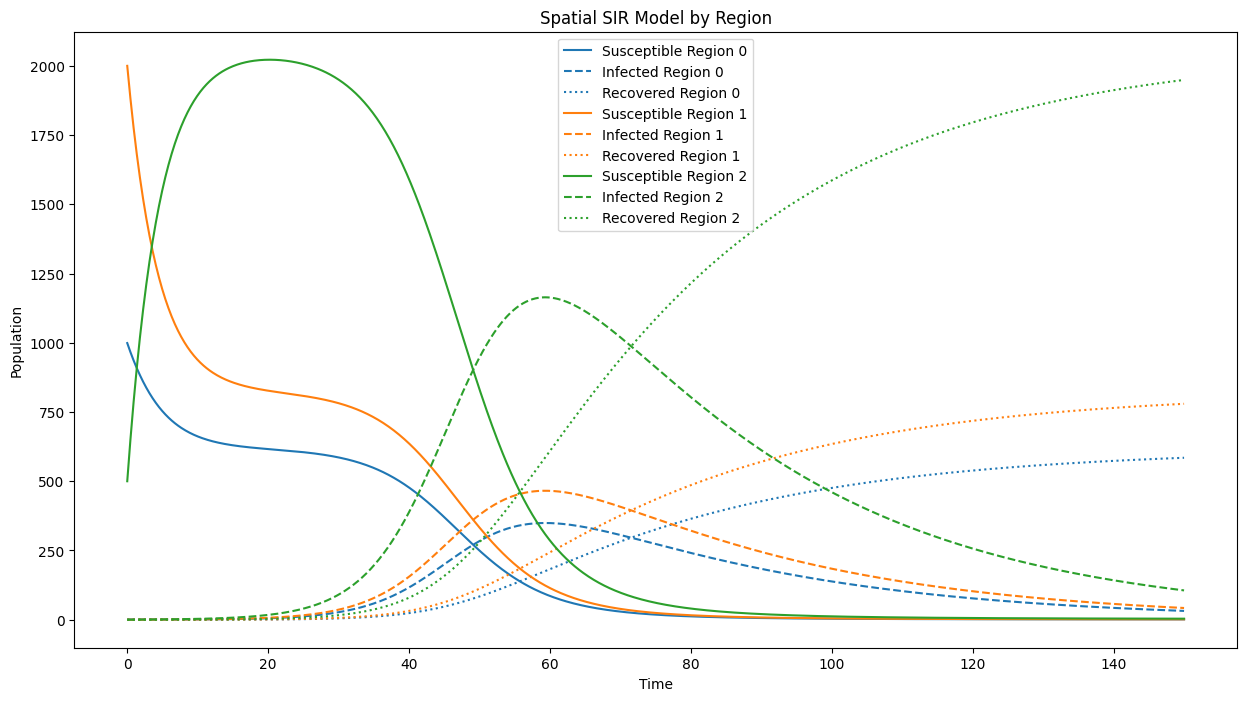

In [41]:
n_regions = int(len(initial_populations)/3)

colors = plt.cm.tab10.colors

plt.figure(figsize=(15,8))
for loc in range(n_regions):
    # plot S in loc
    plt.plot(time_vec, soln[loc*3], 
             label=f'Susceptible Region {loc}', color=colors[loc], linestyle='-')
    # plot I in loc
    plt.plot(time_vec, soln[loc*3+1], 
             label=f'Infected Region {loc}', color=colors[loc], linestyle='--')
    # plot R in loc
    plt.plot(time_vec, soln[loc*3+2], 
             label=f'Recovered Region {loc}', color=colors[loc], linestyle=':')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Spatial SIR Model by Region')
plt.legend()
plt.show()
    

N = [1000, 5000]  # Denver, Chicago population

migration_matrix = [
    [0, 0.1],  # movement from Denver to Chicago
    [0.2, 0]
]

# y is a list of all SIR for each region
y = [0_S, 0_I, 0_R, 1_S, 1_I, 1_R, ...]

In [ ]:
# location information is a list of regions
location_information = [
    {'name': 'Hartford',
     'initial_population': 1000,
     'location': (100, 10)  # x and y position
    }, 
    {'name': 'Denver',
     'initial_population': 2000,
     'location': (50, 8)
    }, 
    {'name': 'San Francisco',
     'initial_population': 4000,
     'location': (10, 20)
    }
]

# assume migration is a function of distance Mi->j = c/distance
# TODO -- the number of regions will be a function of the number of entries
# TODO -- create a migration matrix from these locations, and run the generic SIR model with it

def run_sir(location_information):
    migration_matrix = [] # this needs to be generated from the data
    
    # this needs to be generated from the data (number of regions * 3 values (S,I,R))
    initial_populations = []
    
    soln = odeint(
        generic_spatial_sir, 
        initial_populations,   
        time_vec, 
        args=(infection_rate, 
              recovery_rate, 
              migration_matrix)
    ).T
    return soln